# Load data 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm.auto import tqdm
from IPython.display import display, HTML
from scipy.stats import norm, beta

home = pd.read_csv('../property.csv')
display(home.head())

print(home.shape)

,item_id,deposit,monthly_rent,district_uuid,room_qty,unit_area,has_elevator,building_floor_count,unit_floor,has_storage_area,property_age
0,91c0e569-bddd-4128-9720-2550bb85580e,64800000.0,0,263682f6-d0cd-4569-aeec-e727b76b7665,1.0,42,False,3.0,0.0,True,23.0
1,b00b7919-06be-4d26-98b8-1971787e1d46,72000000.0,4320000,97c9535e-3985-47ce-a84c-a962c838a76b,2.0,116,True,NaN,1.0,True,16.0
2,9eddb6bc-e424-4774-b55f-bfd54366d627,50400000.0,1440000,b790f536-c274-4147-86e0-94d9b6d7352d,1.0,74,False,2.0,0.0,True,19.0
3,12cf6b07-5d56-4126-94d2-ce9cbfe2214f,36000000.0,864000,93d06676-4975-4cc5-919b-3a0c29c7ad43,1.0,60,True,NaN,2.0,False,6.0
4,929eb20c-3694-46b2-b96c-91117b995d1b,28800000.0,1296000,58e59fa9-9947-478f-9cef-bc6a2cbe49a9,1.0,45,True,NaN,1.0,True,4.0


(4930, 11)


# Preprocessing

## Drop NaN 

In [2]:
# allow deposit 0
# drop 0 value on  'unit_area', 'room_qty'
# drop nan on 'district_uuid','room_qty','property_age','deposit','has_storage_area','unit_floor'
clean_home = (home
              .loc[~((home['unit_area'] == 0)|(home['room_qty'] == 0))]
              .dropna(subset=['district_uuid',
                              'room_qty',
                              'property_age',
                              'deposit',
                              'has_storage_area',
                              'has_elevator',
                              'unit_floor'])
             )
# clean_home['has_storage_area'] = clean_home['has_storage_area'].map({True:1,False:0})
# clean_home['has_elevator'] = clean_home['has_elevator'].map({True:1,False:0})

## Imputing building_floor_count

In [3]:
import fancyimpute
# select only numrical columns
X = clean_home[[c for c in clean_home.columns if c not in ['item_id','district_uuid']]].copy()

# Use 3 nearest rows which have a feature to fill in each row's missing features
X_filled_knn = fancyimpute.KNN(k=3).fit_transform(X)

# round the number
clean_home['imputing_building_floor_count'] = X_filled_knn[:,5]

Imputing row 1/4783 with 0 missing, elapsed time: 1.452
Imputing row 101/4783 with 0 missing, elapsed time: 1.453
Imputing row 201/4783 with 0 missing, elapsed time: 1.454
Imputing row 301/4783 with 1 missing, elapsed time: 1.455
Imputing row 401/4783 with 1 missing, elapsed time: 1.455
Imputing row 501/4783 with 0 missing, elapsed time: 1.456
Imputing row 601/4783 with 1 missing, elapsed time: 1.457
Imputing row 701/4783 with 0 missing, elapsed time: 1.458
Imputing row 801/4783 with 1 missing, elapsed time: 1.459
Imputing row 901/4783 with 1 missing, elapsed time: 1.460
Imputing row 1001/4783 with 1 missing, elapsed time: 1.461
Imputing row 1101/4783 with 0 missing, elapsed time: 1.462
Imputing row 1201/4783 with 1 missing, elapsed time: 1.462
Imputing row 1301/4783 with 0 missing, elapsed time: 1.464
Imputing row 1401/4783 with 0 missing, elapsed time: 1.464
Imputing row 1501/4783 with 0 missing, elapsed time: 1.465
Imputing row 1601/4783 with 0 missing, elapsed time: 1.466
Imputing 

# Categorize Features ( Feature Engineering)
convert every feature to categorical features as interval bin

In [4]:
import math
from pandas.api.types import CategoricalDtype
def gen_labels(number_range):
    labels = []
    for i, value in enumerate(number_range):
    #     old_value = value
        if i == 0:
            pass
        elif i+1 == len(number_range):
            labels.append(f"{number_range[i-1]}+")
        else:
            labels.append(f"{number_range[i-1]}-{value}")
        old_value = value
    return labels

def get_cut_extreme_to_inf(numbers, w):
    # w is how many bins
    max_range_bin = np.quantile(numbers,0.95)
    min_range_bin = min(numbers)
    n = math.ceil((max_range_bin - min_range_bin)/w)
    range_numbers = [-np.inf]+list(np.arange(min_range_bin, max_range_bin+1, n)) + [+np.inf]
    # labels = gen_labels(range_numbers)
    # return pd.cut(numbers ,range_numbers, labels)
    return pd.cut(numbers ,range_numbers)


In [5]:
# Not eqaully distributed value
# clean_home['deposit_bin'] = get_cut_extreme_to_inf(clean_home['deposit'],10)
# clean_home['monthly_rent_bin'] = get_cut_extreme_to_inf(clean_home['monthly_rent'],10)
# clean_home['property_age_bin'] = get_cut_extreme_to_inf(clean_home['property_age'],10)
# clean_home['unit_area_bin'] = get_cut_extreme_to_inf(clean_home['unit_area'],10)
# clean_home['imputing_building_floor_count_bin'] = get_cut_extreme_to_inf(clean_home['imputing_building_floor_count'],10)
# sorted([(k,v) for k,v in  get_cut_extreme_to_inf(clean_home['unit_area'],10).value_counts().items()], key = lambda d : d[0])

## unit_area

In [6]:
def group_interval_unit_area(interval):
    if (0 in interval)|(5 in interval)|(17 in interval)|(29 in interval)|(41.0 in interval):
        return pd.Interval(-np.inf,41.0,closed='right')
    elif (101.0 in interval) | (113.0 in interval)| (np.inf in interval):
        return pd.Interval(89.0, np.inf,closed='right')
    else:
        return interval
    
clean_home['unit_area_bin'] = (
    get_cut_extreme_to_inf(clean_home['unit_area'],10)
    .astype(object)
    .apply( lambda interval : group_interval_unit_area(interval))
    .astype("category")
)

In [7]:
sorted([(k,v) for k,v in  clean_home['unit_area_bin'].value_counts().items()], key = lambda d : d[0])

[(Interval(-inf, 41.0, closed='right'), 86),
 (Interval(41.0, 53.0, closed='right'), 938),
 (Interval(53.0, 65.0, closed='right'), 1236),
 (Interval(65.0, 77.0, closed='right'), 905),
 (Interval(77.0, 89.0, closed='right'), 763),
 (Interval(89.0, inf, closed='right'), 855)]

## Property Age 

In [8]:
def group_interval_property_age(interval):
    if (0 in interval)|(3 in interval):
        return pd.Interval(-np.inf,3,closed='right')
    elif (24.0 in interval) | (27.0 in interval)| (30.0 in interval) | (np.inf in interval):
        return pd.Interval(21.0, np.inf,closed='right')
    else:
        return interval
    
clean_home['property_age_bin'] = (
    get_cut_extreme_to_inf(clean_home['property_age'],10)
    .astype(object)
    .apply( lambda interval : group_interval_property_age(interval))
    .astype("category")
)

In [9]:
sorted([(k,v) for k,v in  clean_home['property_age_bin'].value_counts().items()], key = lambda d : d[0])

[(Interval(-inf, 3.0, closed='right'), 479),
 (Interval(3.0, 6.0, closed='right'), 541),
 (Interval(6.0, 9.0, closed='right'), 546),
 (Interval(9.0, 12.0, closed='right'), 596),
 (Interval(12.0, 15.0, closed='right'), 860),
 (Interval(15.0, 18.0, closed='right'), 612),
 (Interval(18.0, 21.0, closed='right'), 555),
 (Interval(21.0, inf, closed='right'), 594)]

## Deposit 

In [10]:
def group_interval_deposit_bin(interval):
    if (18720000 in interval)|(0 in interval):
        return pd.Interval(-np.inf,18720000,closed='right')
    elif (168480000 in interval) | (187200000 in interval)| (np.inf in interval) :
        return pd.Interval(149760000.0, np.inf,closed='right')
    else:
        return interval

clean_home['deposit_bin'] = (
    get_cut_extreme_to_inf(clean_home['deposit'],10)
    .astype(object)
    .apply( lambda interval : group_interval_deposit_bin(interval))
    .astype("category")
)

In [11]:
sorted([(k,v) for k,v in  clean_home['deposit_bin'].value_counts().items()], key = lambda d : d[0])

[(Interval(-inf, 18720000.0, closed='right'), 192),
 (Interval(18720000.0, 37440000.0, closed='right'), 920),
 (Interval(37440000.0, 56160000.0, closed='right'), 527),
 (Interval(56160000.0, 74880000.0, closed='right'), 937),
 (Interval(74880000.0, 93600000.0, closed='right'), 599),
 (Interval(93600000.0, 112320000.0, closed='right'), 453),
 (Interval(112320000.0, 131040000.0, closed='right'), 321),
 (Interval(131040000.0, 149760000.0, closed='right'), 307),
 (Interval(149760000.0, inf, closed='right'), 527)]

## Monthly rent 

In [12]:
def group_interval_monthly_rent(n):
    if  0 < n <= 1641600.0:
        #return pd.Interval(0,1641600.0,closed='right')
        return "medium"
    elif n > 1641600.0:
        #return pd.Interval(1641600.0,np.inf,closed='right')
        return "expensive"
    elif n <= 0:
        return "not_allowed_rent"
        #return pd.Interval(-np.inf,0,closed='right')

cat_type = CategoricalDtype(categories=["not_allowed_rent", "medium", "expensive"], ordered=True)
clean_home['monthly_rent_bin'] = (clean_home['monthly_rent']
                                                   .apply(group_interval_monthly_rent)
                                                   .astype(cat_type)
                                                  )

In [13]:
sorted([(k,v) for k,v in  clean_home['monthly_rent_bin'].value_counts().items()], key = lambda d : d[0])

[('expensive', 1043), ('medium', 1940), ('not_allowed_rent', 1800)]

## Building Floor count

In [14]:
def group_interval_building_floor_count(n):
    if  3 < n <= 4:
        return "4"
        #return pd.Interval(n-1,n,closed='right')
    elif n > 4:
        return "more_than_4"
        #return pd.Interval(4,np.inf,closed='right')
    elif n <= 3:
        return "less_than_4"
        #return pd.Interval(-np.inf,3,closed='right')


clean_home['imputing_building_floor_count_bin'] = (clean_home['imputing_building_floor_count']
                                                   .apply(round)
                                                   .apply(group_interval_building_floor_count)
                                                   .astype(CategoricalDtype(
                                                       categories=["less_than_4", "4", "more_than_4"], 
                                                       ordered=True)
                                                          )
                                                  )

In [15]:
clean_home['imputing_building_floor_count_bin'].value_counts()

imputing_building_floor_count_bin
4              2528
less_than_4    1234
more_than_4    1021
Name: count, dtype: int64

## Unit Floor

In [16]:
def group_interval_unit_floor(n):
    if  0 < n <= 3:
        return f"{int(n)}"
        #return pd.Interval(n-1,n,closed='right')
    elif n > 3:
        return ">= 4"
        #return pd.Interval(4,np.inf,closed='right')
    elif n <= 0:
        return "<= 0"
        #return pd.Interval(-np.inf,0,closed='right')
    
clean_home['unit_floor_bin'] =(clean_home['unit_floor']
                               .apply(group_interval_unit_floor)
                               .astype(CategoricalDtype(
                                                       categories=["<= 0","1","2","3",">= 4"], 
                                                       ordered=True))
                              )

## Room qty 

In [17]:
def group_interval_room_qty(n):
    if  0 < n <= 1:
        return "1"
        #return pd.Interval(n-1,n,closed='right')
    elif n > 1:
        return ">= 2"
        #return pd.Interval(1,np.inf,closed='right')
    elif n <= 0:
        return "<= 0"
        #return pd.Interval(-np.inf,0,closed='right')
clean_home['room_qty_bin'] = (clean_home['room_qty']
                              .apply(group_interval_room_qty)
#                               .astype("category")
                              .astype(CategoricalDtype(
                                                       categories=["<= 0","1",">= 2"], 
                                                       ordered=True)))

In [18]:
clean_home['room_qty_bin'].value_counts()

room_qty_bin
1       2504
>= 2    2279
<= 0       0
Name: count, dtype: int64

## District UUID 

In [19]:
top_100_district_uuid_list = list(clean_home['district_uuid'].value_counts().head(100).keys())
clean_home['top_100_district_uuid'] = clean_home['district_uuid'].apply(lambda uuid : uuid if uuid in top_100_district_uuid_list else 'other').astype("category")

In [20]:
categorized_clean_home = clean_home.loc[:,['deposit_bin','monthly_rent_bin','property_age_bin','unit_area_bin',
            'has_elevator','has_storage_area',
            'unit_floor_bin', 'room_qty_bin',
            'imputing_building_floor_count_bin',
            'top_100_district_uuid'
           ]].copy()

## EDA Categorized Feature

### Thoughts
* according to cramer's correlations : 
    *  unit area, room qty are strongly associated
    *  monthly rent, deposit are strongly associated
    *  property age, has elevator  are strongly associated
 

# Preprocessing

In [21]:
from sklearn import preprocessing
labelencoder_for_feature = { col : preprocessing.LabelEncoder() for col in categorized_clean_home.columns }
encoded_data = categorized_clean_home.copy()
for col in categorized_clean_home.columns:
    encoded_data[col] = labelencoder_for_feature[col].fit_transform(categorized_clean_home[col])

# Custering

In [22]:
from kmodes.kmodes import KModes

## Cao algorithm 

In [23]:
cao_kmode_models = []
cao_costs = []
for n in tqdm(range(2,5,1)):
    km_cao = KModes(n_clusters=n, init = "Cao",n_jobs=-1, random_state=2022)
    fitClusters_cao = km_cao.fit_predict(encoded_data)
    cao_kmode_models.append(km_cao)
    cao_costs.append(km_cao.cost_)

selected_model = cao_kmode_models[2]  # 假设索引2对应4个簇

# 使用所选的聚类模型对数据进行聚类
cluster_labels = selected_model.predict(encoded_data)

# 创建包含特征值和聚类标签的DataFrame
feature_columns = [f"Feature_{i}" for i in range(encoded_data.shape[1])]
data = pd.DataFrame(data=encoded_data, columns=feature_columns)
data['Cluster'] = cluster_labels

from sklearn.metrics import silhouette_score

# 已经从聚类模型中获得的聚类标签
cluster_labels = selected_model.predict(encoded_data)

# 计算轮廓系数
silhouette_avg = silhouette_score(encoded_data, cluster_labels)

print(f"轮廓系数为: {silhouette_avg}")

# 将DataFrame保存为CSV文件
data.to_csv('cluster.csv', index=False)

  0%|          | 0/3 [00:00<?, ?it/s]

轮廓系数为: -0.010408931403896165


## Haung Algorithm

In [27]:
huang_kmode_models = []
huang_costs = []
for n in tqdm(range(2,5,1)):
    km_huang = KModes(n_clusters=n, init = "Huang",n_jobs=-1, random_state=2022)
    fitClusters_huang = km_huang.fit_predict(encoded_data)
    huang_kmode_models.append(km_huang)
    huang_costs.append(km_huang.cost_)
    
selected_model = huang_kmode_models[2]  

# 使用所选的聚类模型对数据进行聚类
cluster_labels = selected_model.predict(encoded_data)

# 创建包含特征值和聚类标签的DataFrame
feature_columns = [f"Feature_{i}" for i in range(encoded_data.shape[1])]
data = pd.DataFrame(data=encoded_data, columns=feature_columns)
data['Cluster'] = cluster_labels

# 计算轮廓系数
silhouette_avg = silhouette_score(encoded_data, cluster_labels)
print(silhouette_avg)

  0%|          | 0/3 [00:00<?, ?it/s]

-0.01855624928960742


## Random

In [28]:
random_kmode_models = []
random_costs = []
for n in tqdm(range(2,5,1)):
    km_random = KModes(n_clusters=n, init = "random",n_jobs=-1, random_state=2022)
    fitClusters_random = km_random.fit_predict(encoded_data)
    random_kmode_models.append(km_random)
    random_costs.append(km_random.cost_)

selected_model = random_kmode_models[2]  

# 使用所选的聚类模型对数据进行聚类
cluster_labels = selected_model.predict(encoded_data)

# 创建包含特征值和聚类标签的DataFrame
feature_columns = [f"Feature_{i}" for i in range(encoded_data.shape[1])]
data = pd.DataFrame(data=encoded_data, columns=feature_columns)
data['Cluster'] = cluster_labels

# 计算轮廓系数
silhouette_avg = silhouette_score(encoded_data, cluster_labels)
print(silhouette_avg)


  0%|          | 0/3 [00:00<?, ?it/s]

-0.027193611620017582


## Check appropriate K clusters

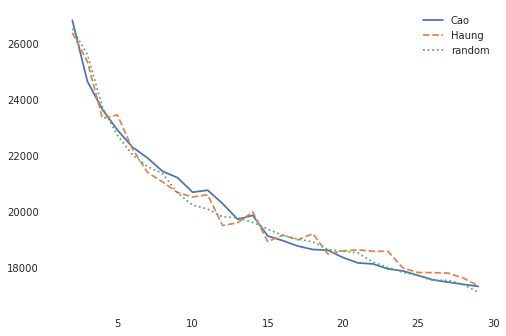

<Figure size 576x396 with 0 Axes>

In [ ]:
plt.plot([*range(2,30,1)],cao_costs, linestyle ='-')
plt.plot([*range(2,30,1)],huang_costs, linestyle='--')
plt.plot([*range(2,30,1)],random_costs, linestyle='dotted')
plt.legend(['Cao','Haung','random'])
plt.figure(20)
plt.show()

### Thoughts
* around 10-13 probalby apropriate clusters
* lets choose 10 with cao initial

## Chosen random K-mode 10 clusters

In [ ]:
chosen_model = random_kmode_models[8]
print(chosen_model)

KModes(init='random', n_clusters=10, n_jobs=-1, random_state=2022)


In [ ]:
# save the model
import pickle
pickle.dump(chosen_model, open("random_kmode_10_cluster_model.pkl", "wb"))

### Label Distribution

[659 814 357 488 725 324 423 351 327 315]


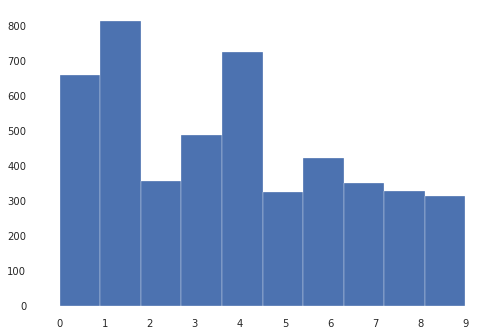

In [ ]:
labels = chosen_model.labels_
counts = np.bincount(labels[labels>=0])
print(counts)
plt.hist([str(n) for n in sorted(labels)])
plt.show()

### Thoughts
* not unifrom distribution, which is bad

### Centroids Analysis

In [ ]:
import plotly.graph_objects as go
import numpy as np
def plot_boundary_line(boundary_feature):
    x_array = []
    y_array = []
    for cluster,interval in centroids_df[boundary_feature].items():
        x_array.append([cluster,cluster])
        y_array.append([interval.left, interval.right])
    fig = go.Figure(data=[go.Scatter(x=y, y=x,name=f"cluster {x[0]}",line=dict(width=10), marker=dict(size=10)) for x,y in zip(x_array,y_array)])
    fig.update_layout({'title' : f"{boundary_feature} Boundary"})
    return fig

In [ ]:
centroids = chosen_model.cluster_centroids_ 
centroids_df = pd.DataFrame(centroids, columns=encoded_data.columns)
for col in centroids_df.columns:
    centroids_df[col] = labelencoder_for_feature[col].inverse_transform(centroids_df[col])

centroids_df.to_csv('centroid_df.csv')
display(centroids_df)

,deposit_bin,monthly_rent_bin,property_age_bin,unit_area_bin,has_elevator,has_storage_area,unit_floor_bin,room_qty_bin,imputing_building_floor_count_bin,top_100_district_uuid
0,"(56160000.0, 74880000.0]",medium,"(12.0, 15.0]","(77.0, 89.0]",False,False,1,>= 2,4,fd5ad07f-14b2-4491-aeb3-31651e92e1fd
1,"(18720000.0, 37440000.0]",medium,"(15.0, 18.0]","(41.0, 53.0]",False,True,3,1,less_than_4,b790f536-c274-4147-86e0-94d9b6d7352d
2,"(131040000.0, 149760000.0]",not_allowed_rent,"(21.0, inf]","(77.0, 89.0]",False,False,1,>= 2,less_than_4,b790f536-c274-4147-86e0-94d9b6d7352d
3,"(149760000.0, inf]",not_allowed_rent,"(3.0, 6.0]","(89.0, inf]",True,True,2,>= 2,more_than_4,fd5ad07f-14b2-4491-aeb3-31651e92e1fd
4,"(74880000.0, 93600000.0]",not_allowed_rent,"(18.0, 21.0]","(53.0, 65.0]",False,True,1,1,4,b790f536-c274-4147-86e0-94d9b6d7352d
5,"(56160000.0, 74880000.0]",expensive,"(3.0, 6.0]","(65.0, 77.0]",True,True,2,>= 2,4,fd5ad07f-14b2-4491-aeb3-31651e92e1fd
6,"(18720000.0, 37440000.0]",medium,"(18.0, 21.0]","(53.0, 65.0]",False,False,2,1,4,b790f536-c274-4147-86e0-94d9b6d7352d
7,"(149760000.0, inf]",not_allowed_rent,"(-inf, 3.0]","(89.0, inf]",True,True,>= 4,>= 2,more_than_4,fd5ad07f-14b2-4491-aeb3-31651e92e1fd
8,"(56160000.0, 74880000.0]",expensive,"(21.0, inf]","(89.0, inf]",False,True,3,>= 2,4,1c10c124-59c8-4f0f-954d-1b1993c1c01b
9,"(56160000.0, 74880000.0]",medium,"(3.0, 6.0]","(41.0, 53.0]",True,True,2,1,4,b790f536-c274-4147-86e0-94d9b6d7352d


In [ ]:
plot_boundary_line('deposit_bin')

In [ ]:
plot_boundary_line('property_age_bin')

In [ ]:
plot_boundary_line('unit_area_bin')

In [ ]:
categorized_clean_home['kmode_cluster'] = labels

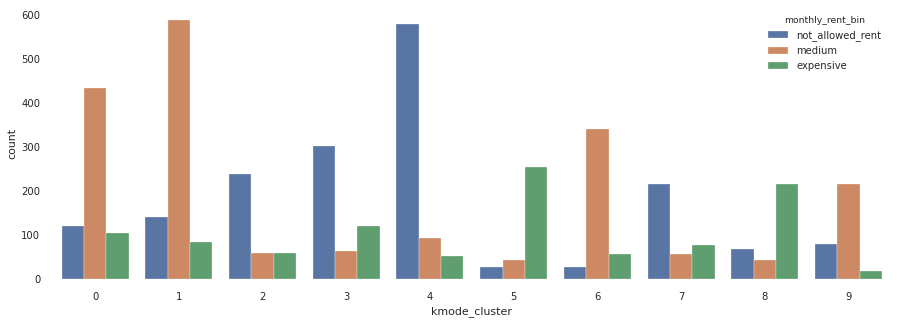

In [ ]:
plt.subplots(figsize = (15,5))
sns.countplot(x='kmode_cluster',hue='monthly_rent_bin', data = categorized_clean_home)
plt.show()

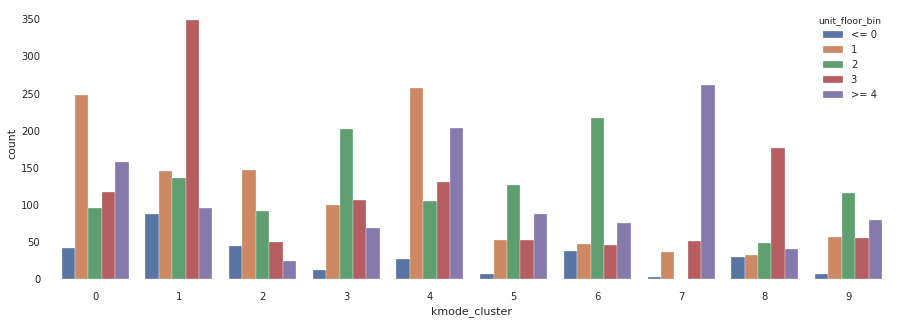

In [ ]:
plt.subplots(figsize = (15,5))
sns.countplot(x='kmode_cluster',hue='unit_floor_bin', data = categorized_clean_home)
plt.show()

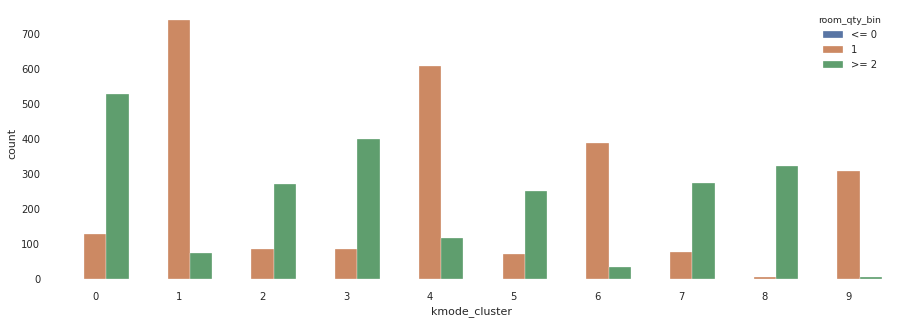

In [ ]:
plt.subplots(figsize = (15,5))
sns.countplot(x='kmode_cluster',hue='room_qty_bin', data = categorized_clean_home)
plt.show()

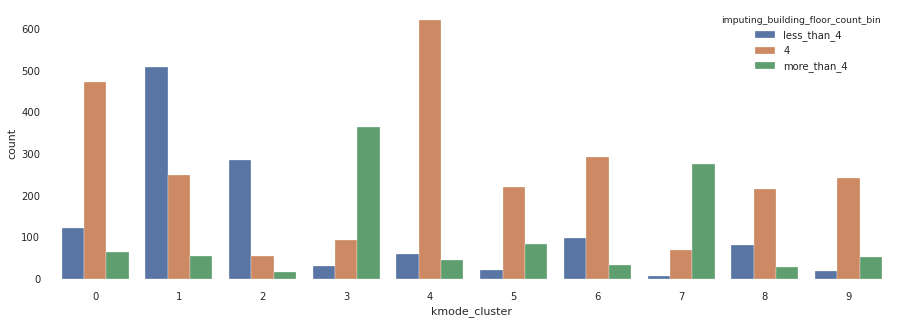

In [ ]:
plt.subplots(figsize = (15,5))
sns.countplot(x='kmode_cluster',hue='imputing_building_floor_count_bin', data = categorized_clean_home)
plt.show()

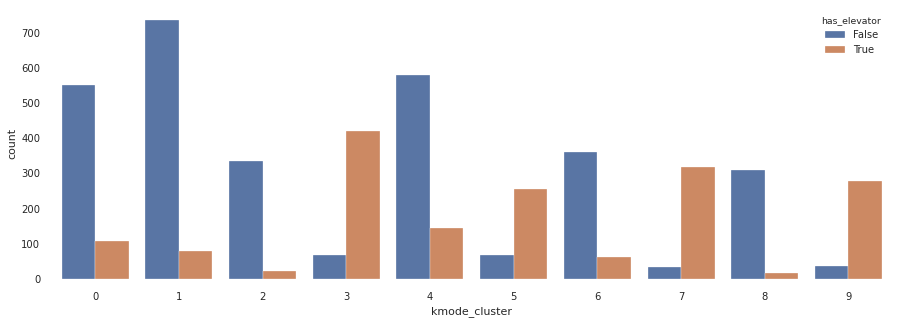

In [ ]:
plt.subplots(figsize = (15,5))
sns.countplot(x='kmode_cluster',hue='has_elevator', data = categorized_clean_home)
plt.show()

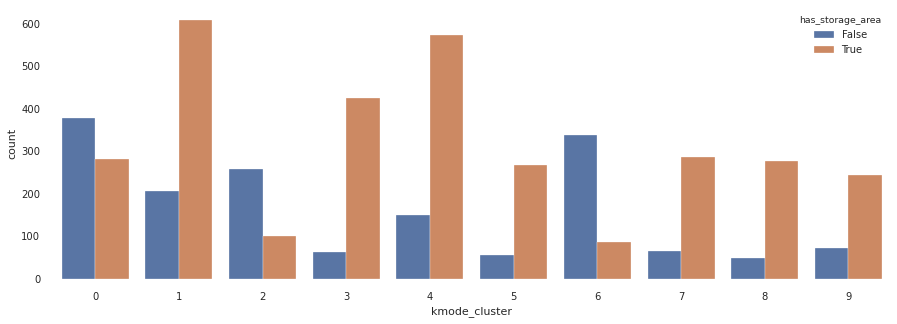

In [ ]:
plt.subplots(figsize = (15,5))
sns.countplot(x='kmode_cluster',hue='has_storage_area', data = categorized_clean_home)
plt.show()

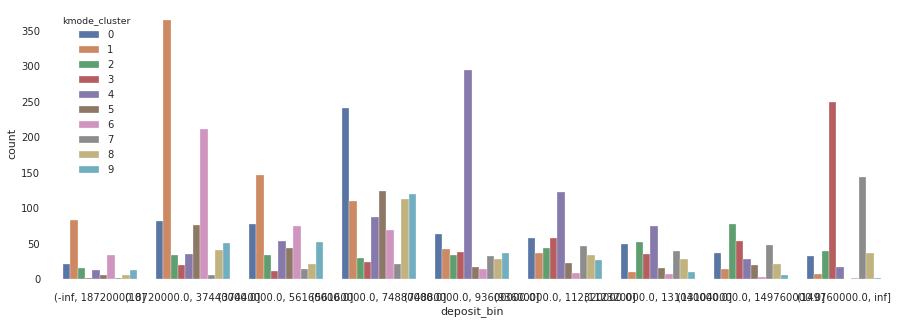

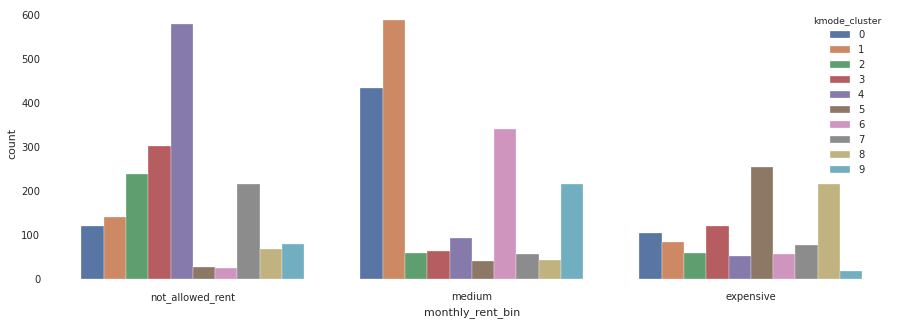

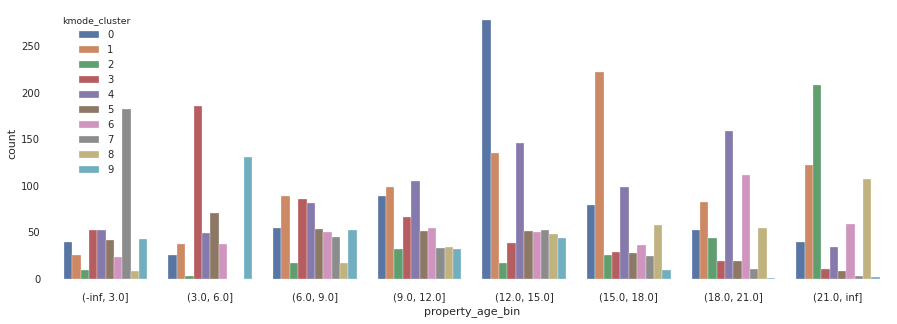

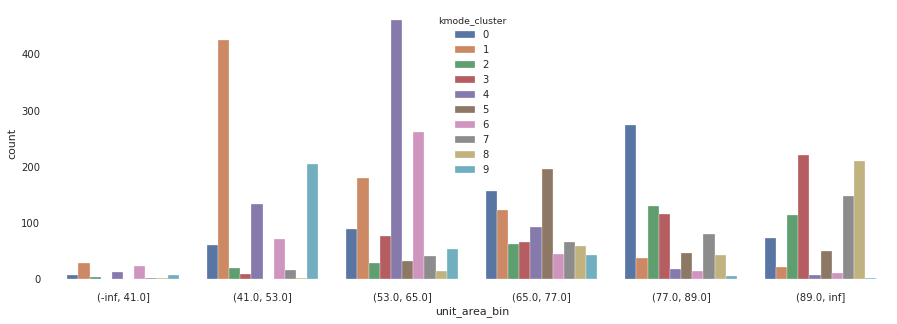

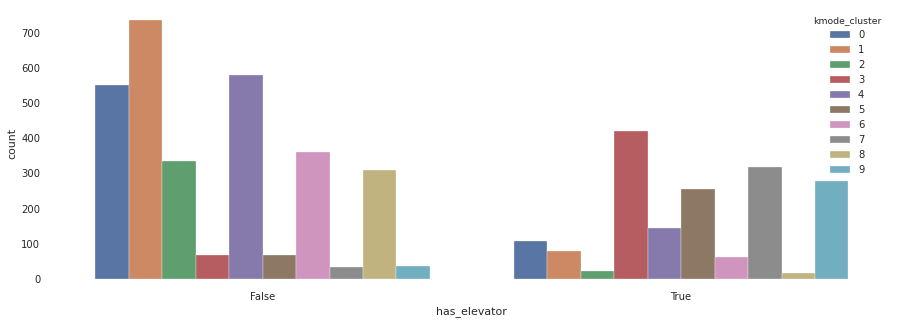

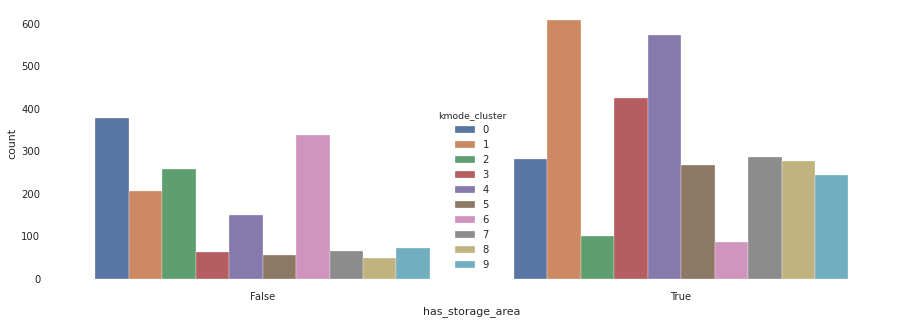

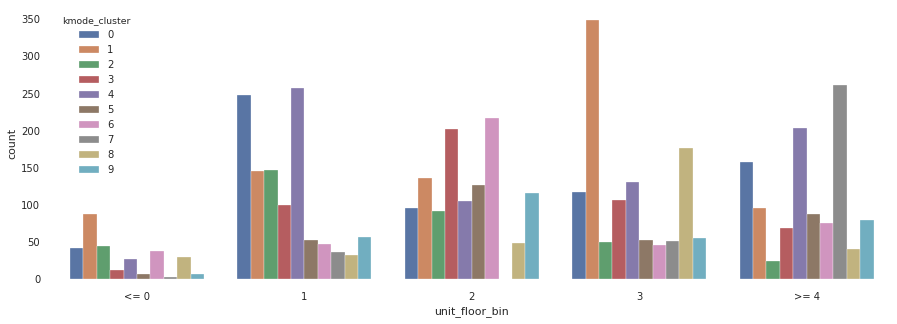

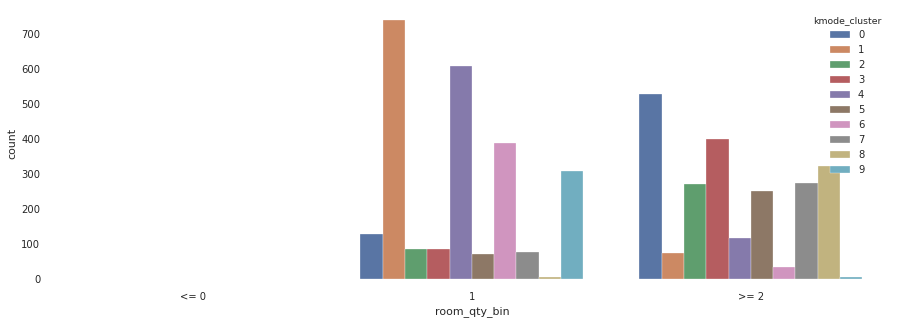

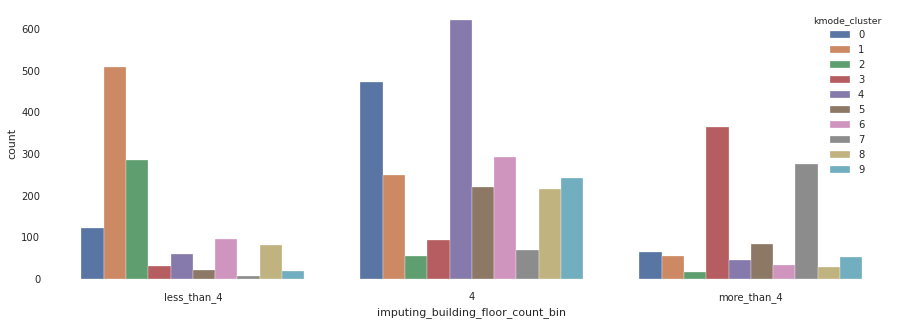

In [ ]:
for col in [c for c in categorized_clean_home.columns if c not in ['kmode_cluster','top_100_district_uuid']]:
    plt.subplots(figsize = (15,5))
    sns.countplot(x=col,hue="kmode_cluster", data = categorized_clean_home)
    plt.show()